In [1]:
import itertools
import numpy as np
import functools

In [2]:
%display latex

In [3]:
def same(*args):
    for arg in args:
        assert args[0] == arg
    return args[0]

In [4]:
class GaussQuad:
    def __init__(self, alphas, betas, wf):
        self.n = same(len(alphas), len(betas))
        
        self.wf = wf
    
        J = np.zeros((self.n, self.n))
        for k, alpha, beta in zip(range(self.n), alphas, betas):
            J[k, k] = alpha
            if k-1 >= 0:
                J[k-1, k] = sqrt(beta)
                J[k, k-1] = sqrt(beta)

        x = var("x")
        polys = [0, 1]
        for k, alpha, beta in zip(itertools.count(2), alphas, betas):
            poly = (x - alpha)*polys[k-1] - beta*polys[k-2]
            polys.append(poly)
        self.poly = polys[-1]
        self.poly = self.poly.full_simplify()
        
        # Eigenvectors are returned in normalized form.
        # eig.eigenvectors[vector_dimension,vector]
        eig = np.linalg.eig(J)
        eig_val = eig.eigenvalues
        eig_vec = eig.eigenvectors.T

        self.x = eig_val.tolist()
        v = eig_vec.tolist()

        self.w = []
        for k in range(self.n):
            self.w.append(betas[0]*v[k][0]**2)
    
    @property
    def sx(self):
        return var("x")
    
    @property
    def sf(self):
        return function("f")
    
    @functools.cached_property
    def quad(self):
        quad = 0
        for xv, wv in zip(self.x, self.w):
            quad += wv*(self.sf)(xv)
        return quad
    
    @functools.cached_property
    def poly_norm(self):
        coef = max(self.poly.coefficients(), key=lambda a: a[1])[0]
        poly = self.poly / coef
        return poly
        
    @property
    def rest(self):
        a = var("a")
        b = var("b")
        
        with assuming(a < b):
            rest = (
                diff((self.sf)(self.sx), self.sx, 2*self.n)
                / factorial(2*self.n)
                * integral(self.wf(self.sx)*self.poly_norm**2, self.sx, a, b)
            )
        return rest

In [5]:
def chebyshev_values_2(n):
    alphas = []
    betas = []
    for k in range(n):
        alphas.append(0)
        if k == 0:
            betas.append(1/2 * pi)
        else:
            betas.append(1/4)
    
    w = function("w")
    x = var("x")
    w(x) = (1-x**2)**(1/2)
    
    return alphas, betas, w

# Rezolvare

## Prelucrare integrala

Incepem cu:
$$
\int_1^2\sqrt{-t^2+3t-2}\sin{t}\text dt
$$

Substituim $t$ cu $u=2t-3$, $\Rightarrow t=\frac{u+3}{2}, \text du=2dt$:

$$
\int_{-1}^1\sqrt{\frac{1}{4}-\frac{1}{4}u^2}\frac{1}{2}\sin\left(\frac{u+3}{2}\right)\text du
$$

Factorizam cu $\frac{1}{4}$ in radical:

$$
\int_{-1}^1\sqrt{1-u^2}\frac{1}{4}\sin\left(\frac{u+3}{2}\right)\text du
$$


Am obtinut integrala intr-o forma, in care se poate calcula folosind cuadratura de tip Gauss-Cebasev #2.

## Rest

Deoarece $f(x)=\sin{x}$, iar $\sin^{(n)}(x)\le1,\forall n\in N, x\in R$, substituim derivata lui $f$ din formula restului cu $1$.

6

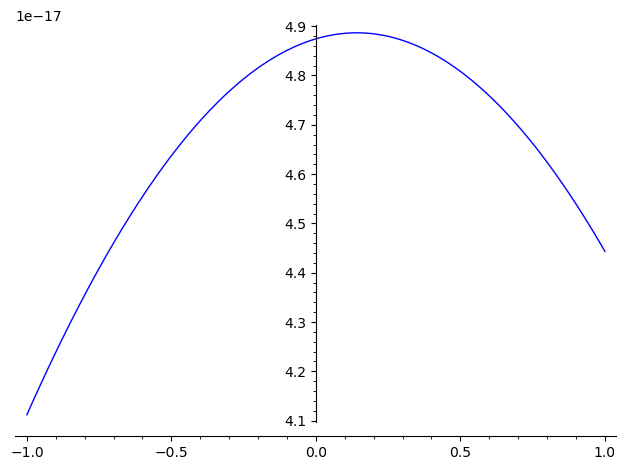

In [6]:
x = var("x")
fv = function("f")
fv(x) = (1/4) * sin((x+3)/2)

n = 1
while True:
    gq = GaussQuad(*chebyshev_values_2(n))
    rest = (
        1
        / factorial(2*n)
        * integral(gq.wf(gq.sx)*gq.poly_norm**2, gq.sx, -1, 1)
    )
    if rest < 10**(-10):
        break
    n += 1
display(n)
rest = gq.rest.substitute(a=-1, b=1).substitute_function(gq.sf, fv)
plot(rest, -1, 1)

In [7]:
print("Valoarea integralei")
display((gq.quad.substitute_function(gq.sf, fv)).n())

Valoarea integralei


0.379601109535519

In [8]:
print("Verificare")
display(integral(sqrt(3*x - x**2 - 2)*sin(x), x, 1, 2).n())

Verificare


0.3796011130954259